In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist


In [3]:
def initialize_membership(n_samples, n_clusters):
    u = np.random.rand(n_samples, n_clusters)
    return u / np.sum(u, axis=1, keepdims=True)

In [4]:
def compute_centroids(data, membership, m):
    um = membership ** m
    return (um.T @ data) / np.sum(um.T, axis=1, keepdims=True)

In [5]:
def update_membership(data, centroids, m):
    distances = cdist(data, centroids, metric='euclidean')
    distances = np.fmax(distances, 1e-10)  # Tránh chia cho 0
    inv_distances = 1.0 / distances
    exponent = 2.0 / (m - 1)
    return (inv_distances / np.sum(inv_distances[:, :, None] ** exponent, axis=1)).squeeze()

In [6]:
def create_u_bar(labels, n_clusters, supervised_ratio):
    n_samples = len(labels)
    supervised_count = int(n_samples * supervised_ratio)
    supervised_indices = np.random.choice(n_samples, supervised_count, replace=False)
    
    u_bar = np.zeros((n_samples, n_clusters))
    le = LabelEncoder()
    int_labels = le.fit_transform(labels)
    u_bar[supervised_indices, int_labels[supervised_indices]] = 1.0
    
    return u_bar

In [7]:
def ssfcm_clustering(data, labels, n_clusters, m=2, epsilon=1e-5, max_iter=300, supervised_ratio=0.3):
    n_samples = data.shape[0]
    membership_matrix = initialize_membership(n_samples, n_clusters)
    u_bar = create_u_bar(labels, n_clusters, supervised_ratio)
    
    for _ in range(max_iter):
        prev_membership = membership_matrix.copy()
        centroids = compute_centroids(data, membership_matrix - u_bar, m)
        membership_matrix = update_membership(data, centroids, m)
        membership_matrix = u_bar + (1 - np.sum(u_bar, axis=1, keepdims=True)) * membership_matrix
        
        if np.linalg.norm(membership_matrix - prev_membership) < epsilon:
            break
    
    return centroids, membership_matrix

Dataset: D:/Truong_NCKH/Data/Iris.csv
Davies-Bouldin Index: 1.9666
Silhouette Score: 0.1872
Calinski-Harabasz Index: 105.5183



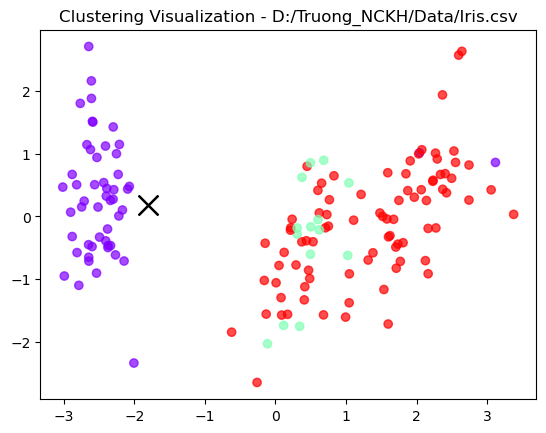

Dataset: D:/Truong_NCKH/Data/Wine.csv
Davies-Bouldin Index: 1.4321
Silhouette Score: -0.3600
Calinski-Harabasz Index: 2.8046



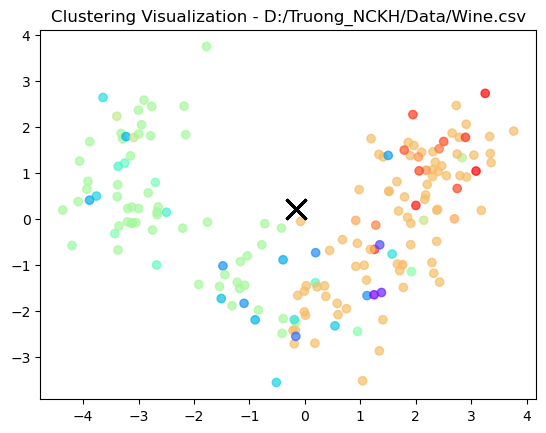

In [8]:
def run_ssfcm_on_dataset(file_path):
    df = pd.read_csv(file_path)
    labels = df.iloc[:, -1].values  # Cột cuối cùng là nhãn
    data = StandardScaler().fit_transform(df.iloc[:, :-1].values)
    
    n_clusters = len(np.unique(labels))
    centroids, membership_matrix = ssfcm_clustering(data, labels, n_clusters)
    
    predicted_labels = np.argmax(membership_matrix, axis=1)
    
    # Đánh giá cụm
    db_index = davies_bouldin_score(data, predicted_labels)
    silhouette = silhouette_score(data, predicted_labels)
    ch_index = calinski_harabasz_score(data, predicted_labels)
    
    print(f"Dataset: {file_path}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}\n")
    
    # Trực quan hóa cụm
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=predicted_labels, cmap='rainbow', alpha=0.7)
    plt.scatter(pca.transform(centroids)[:, 0], pca.transform(centroids)[:, 1], marker='x', s=200, c='black')
    plt.title(f"Clustering Visualization - {file_path}")
    plt.show()

# 7. Chạy trên 3 tập dữ liệu
datasets = [ "D:/Truong_NCKH/Data/Iris.csv", "D:/Truong_NCKH/Data/Wine.csv"]
for dataset in datasets:
    run_ssfcm_on_dataset(dataset)